In [1]:
#data handling
import numpy as np
import pandas as pd
import os
# RDKit modules
import rdkit as rd
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import RDConfig
from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdFingerprintGenerator
from rdkit import DataStructs
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.rdMolDescriptors import GetAtomPairFingerprint
from rdkit.Chem.AtomPairs import Torsions
os.chdir("C:/Users/Welcome/Desktop/MACCS/Main_data")
from collections import Counter

RDKit WARNING: [12:10:59] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
# modeling tools
import sklearn as sk
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from imblearn.over_sampling import ADASYN
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

Using TensorFlow backend.


In [3]:
# graphing tools
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
leads_data_covid = pd.read_csv("combined_data.csv")


In [5]:
#smiles to mol 
leads_data_covid["mol"] = [Chem.MolFromSmiles(x) for x in leads_data_covid["smiles"]]


In [6]:
#count the number of unique rows in the SMILES column
leads_data_covid['smiles'].nunique()

#Compare that with total rows
leads_data_covid['smiles'].count()

#we can drop the duplicated ones
leads_data_covid = leads_data_covid.drop_duplicates(['smiles'])

In [7]:
#create a column for the morgan fingerprints
leads_data_covid["morg_fp"] = [Chem.GetMorganFingerprintAsBitVect(m, 2, nBits = 2048) for m in leads_data_covid['mol']]

# generate morgan fingeprints with radius 2 contained in a list
morg_fp = [Chem.GetMorganFingerprintAsBitVect(m, 2, nBits = 2048) for m in leads_data_covid['mol']]

# convert the RDKit explicit vectors into numpy arrays
morg_fp_np = []
for fp in morg_fp:
  arr = np.zeros((1,))

  DataStructs.ConvertToNumpyArray(fp, arr)
  morg_fp_np.append(arr)

In [8]:
#create a column for the RDKit fingerprints
leads_data_covid["rd_fp"] = [Chem.RDKFingerprint(m) for m in leads_data_covid["mol"]]

#The fingerprinting algorithm used is similar to that used in the Daylight fingerprinter
rd_fp = [Chem.RDKFingerprint(m) for m in leads_data_covid["mol"]]

rd_fp_np = []
for fp in rd_fp:
  arr = np.zeros((1,))
  DataStructs.ConvertToNumpyArray(fp, arr)
  rd_fp_np.append(arr)

In [9]:
#create a column for the Atom-pair fingerprints
leads_data_covid["AP_fp"] = [Chem.GetHashedAtomPairFingerprintAsBitVect(m) for m in leads_data_covid["mol"]]

#get atom-par fingerprints
AP_fp = [Chem.GetHashedAtomPairFingerprintAsBitVect(m) for m in leads_data_covid["mol"]]

#convert the RDKit explicit vectors into numpy arrays
AP_fp_np = []
for fp in AP_fp:
  arr = np.zeros((1,))
  DataStructs.ConvertToNumpyArray(fp, arr)
  AP_fp_np.append(arr)

In [10]:
#create a column for the topological torsion fingerprints
leads_data_covid["torsion_fp"] = torsion_fp = [Chem.GetHashedTopologicalTorsionFingerprintAsBitVect(m) for m in leads_data_covid["mol"]]

#get topological torsion fingerprints
torsion_fp = [Chem.GetHashedTopologicalTorsionFingerprintAsBitVect(m) for m in leads_data_covid["mol"]]

#convert the RDKit explicit vectors into numpy arrays
torsion_fp_np = []
for fp in torsion_fp:
  arr = np.zeros((1,))
  DataStructs.ConvertToNumpyArray(fp, arr)
  torsion_fp_np.append(arr)

In [11]:
#morgan fingerprints
x_morg = morg_fp_np

#daylight-like fingerprints
x_rd = rd_fp_np

#atom-pair fingerprints
x_AP = AP_fp_np

#topological torsion fingerprints
x_torsion = torsion_fp_np

#classification labels
y = leads_data_covid.active.values

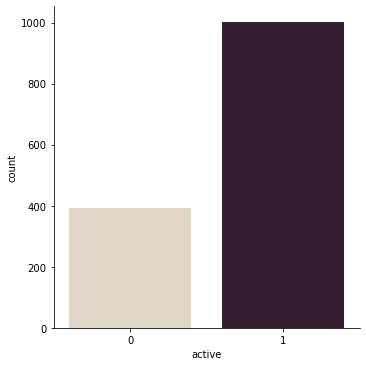

In [12]:
#store the activity labels of all compounds
y = leads_data_covid.active.values

#return the count for each unique value (0 and 1)
unique, counts = np.unique(y, return_counts=True)
dict(zip(unique, counts))

#plot the label counts 
count1 = sns.catplot(x="active", kind="count", palette="ch:.25", data=leads_data_covid)



In [13]:
x_morg_rsmp, y_morg_rsmp = ADASYN().fit_resample(x_morg, y)
morg_sample_count = sorted(Counter(y_morg_rsmp).items())

x_rd_rsmp, y_rd_rsmp = ADASYN().fit_resample(x_rd, y)
rd_sample_count = sorted(Counter(y_rd_rsmp).items())

x_AP_rsmp, y_AP_rsmp = ADASYN().fit_resample(x_AP, y)
AP_sample_count = sorted(Counter(y_rd_rsmp).items())

x_torsion_rsmp, y_torsion_rsmp = ADASYN().fit_resample(x_torsion, y)
torsion_sample_count = sorted(Counter(y_rd_rsmp).items())

print("Morgan distribution:", morg_sample_count, 
      "Daylight-like distribution:", rd_sample_count, 
      "Atom-pair distribution:", AP_sample_count, 
      "Torsion distribution:", torsion_sample_count)


Morgan distribution: [(0, 1070), (1, 1003)] Daylight-like distribution: [(0, 1013), (1, 1003)] Atom-pair distribution: [(0, 1013), (1, 1003)] Torsion distribution: [(0, 1013), (1, 1003)]


In [14]:
#Logistic Regression
#Creating training, testing, and validation test sets
#Partitioning the data into an 85/15 train/test split
x_morg_train, x_morg_test, y_morg_train, y_morg_test = train_test_split(x_morg_rsmp, y_morg_rsmp, test_size=0.15, random_state=1)
#The training data is further split into an 80/15 train/validtion split 
x_morg_train, x_morg_val, y_morg_train, y_morg_val = train_test_split(x_morg_train, y_morg_train, test_size=0.15, random_state=1)

x_rd_train, x_rd_test, y_rd_train, y_rd_test = train_test_split(x_rd_rsmp, y_rd_rsmp, test_size=0.15, random_state=1)
x_rd_train, x_rd_val, y_rd_train, y_rd_val = train_test_split(x_rd_train, y_rd_train, test_size=0.15, random_state=1)

x_AP_train, x_AP_test, y_AP_train, y_AP_test = train_test_split(x_AP_rsmp, y_AP_rsmp, test_size=0.15, random_state=1)
x_AP_train, x_AP_val, y_AP_train, y_AP_val = train_test_split(x_AP_train, y_AP_train, test_size=0.15, random_state=1)

x_torsion_train, x_torsion_test, y_torsion_train, y_torsion_test = train_test_split(x_torsion_rsmp, y_torsion_rsmp, test_size=0.15, random_state=1)
x_torsion_train, x_torsion_val, y_torsion_train, y_torsion_val = train_test_split(x_torsion_train, y_torsion_train, test_size=0.15, random_state=1)

In [15]:
#set our linear regression function
lr = LogisticRegression(solver = 'lbfgs', max_iter = 1000)
#fit the data 
#perform 10 fold crossvalidation to estimate accuracy of model
accuracy_morg = cross_val_score(lr, x_morg_train, y_morg_train, scoring='accuracy', cv = 10)

#get the mean of each fold 

print("Accuracy of Model with Cross Validation is:",accuracy_morg.mean() * 100, "(+/- %0.2f)" % accuracy_morg.std())

#Create our model using 10 fold cross valiation, lbfgs, and 1000 iterations - and fit the data to out training set
lr_morg_ = LogisticRegressionCV(cv=10, solver = 'lbfgs', max_iter = 1000).fit(x_morg_train, y_morg_train)

Accuracy of Model with Cross Validation is: 90.64519015659955 (+/- 0.03)


In [16]:
# A function to train the logistic regression classifier on given x and y training sets
def lrCV_model(x_train, y_train):
    lr = LogisticRegression(solver = 'lbfgs', max_iter = 650)
    model_accuracy = cross_val_score(lr, x_train, y_train, scoring='accuracy', cv = 5)
    accuracy_printout = "Accuracy of Model with Cross Validation is:",model_accuracy.mean() * 100, "(+/- %0.2f)" % model_accuracy.std()
    lr_fit = LogisticRegressionCV(cv=5, solver = 'lbfgs', max_iter = 650, multi_class = "ovr", n_jobs = -1).fit(x_train, y_train)
    
    return lr_fit

In [17]:
#train logistic regression models for all fingerprints
lr_morg = lrCV_model(x_morg_train, y_morg_train)
lr_rd = lrCV_model(x_rd_train, y_rd_train)
lr_AP = lrCV_model(x_AP_train, y_AP_train)
lr_torsion = lrCV_model(x_torsion_train, y_torsion_train)

In [18]:
#predicting using the test set and creating a confusion matrix
predictions_morg_test = lr_morg.predict(x_morg_test)

#confustion matrix for test set predictions
cm_morg_test = metrics.confusion_matrix(y_morg_test, predictions_morg_test)

print(cm_morg_test)

[[152   5]
 [ 18 136]]


In [19]:
#predicting using the validation set and creating a confusion matrix
predictions_morg_val = lr_morg.predict(x_morg_val)

#confustion matrix for validation set predictions
cm_morg_val = metrics.confusion_matrix(y_morg_val, predictions_morg_val)

print(cm_morg_val)

[[136   7]
 [ 10 112]]


In [20]:
score_morg_train = lr_morg.score(x_morg_train, y_morg_train)
print('Accuracy of logistic regression classifier on train set:', score_morg_train)

Accuracy of logistic regression classifier on train set: 0.9906479625918504


In [21]:
score_morg_test = lr_morg.score(x_morg_test, y_morg_test)
print('Accuracy of logistic regression classifier on test set:', score_morg_test)

Accuracy of logistic regression classifier on test set: 0.9260450160771704


In [22]:
score_morg_val = lr_morg.score(x_morg_val, y_morg_val)
print('Accuracy of logistic regression classifier on test set:', score_morg_val)

Accuracy of logistic regression classifier on test set: 0.9358490566037736


In [23]:
print(classification_report(y_morg_val, predictions_morg_val))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       143
           1       0.94      0.92      0.93       122

    accuracy                           0.94       265
   macro avg       0.94      0.93      0.94       265
weighted avg       0.94      0.94      0.94       265



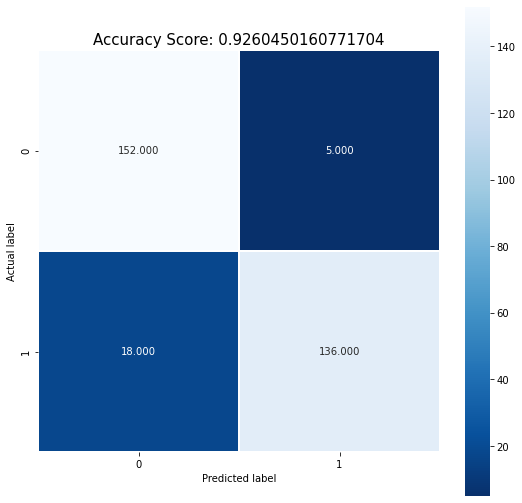

In [24]:
plt.figure(figsize=(9,9))
sns.heatmap(cm_morg_test, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score_morg_test)
plt.title(all_sample_title, size = 15);

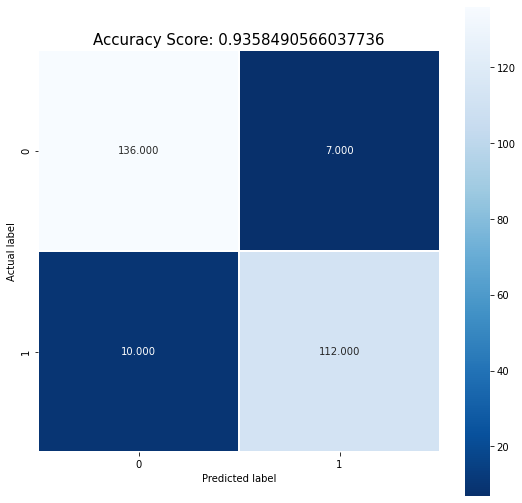

In [25]:
plt.figure(figsize=(9,9))
sns.heatmap(cm_morg_val, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score_morg_val)
plt.title(all_sample_title, size = 15);

In [26]:
#predicting using the test set and creating a confusion matrix
predictions_rd_test = lr_rd.predict(x_rd_test)

#confustion matrix for test set predictions
cm_rd_test = metrics.confusion_matrix(y_rd_test, predictions_rd_test)

#predicting using the validation set and creating a confusion matrix
predictions_rd_val = lr_rd.predict(x_rd_val)

#confustion matrix for test validation predictions
cm_rd_val = metrics.confusion_matrix(y_rd_val, predictions_rd_val)

print(cm_rd_val)

score_rd_train = lr_rd.score(x_rd_train, y_rd_train)
print('Accuracy of logistic regression classifier on train set:', score_rd_train)

score_rd_test = lr_rd.score(x_rd_test, y_rd_test)
print('Accuracy of logistic regression classifier on test set:', score_rd_test)

score_rd_val = lr_rd.score(x_rd_val, y_rd_val)
print('Accuracy of logistic regression classifier on validation set:', score_rd_val)

print(classification_report(y_rd_val, predictions_rd_val))

[[117   2]
 [ 20 118]]
Accuracy of logistic regression classifier on train set: 0.9938186813186813
Accuracy of logistic regression classifier on test set: 0.9174917491749175
Accuracy of logistic regression classifier on validation set: 0.914396887159533
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       119
           1       0.98      0.86      0.91       138

    accuracy                           0.91       257
   macro avg       0.92      0.92      0.91       257
weighted avg       0.92      0.91      0.91       257



In [27]:
#predicting using the test set and creating a confusion matrix
predictions_AP_test = lr_AP.predict(x_AP_test)

#confustion matrix for test set predictions
cm_AP_test = metrics.confusion_matrix(y_AP_test, predictions_AP_test)

print(cm_AP_test)

#predicting using the validation set and creating a confusion matrix
predictions_AP_val = lr_AP.predict(x_AP_val)

#confustion matrix for test validation predictions
cm_AP_val = metrics.confusion_matrix(y_AP_val, predictions_AP_val)

print(cm_AP_val)

score_AP_train = lr_AP.score(x_AP_train, y_AP_train)
print('Accuracy of logistic regression classifier on train set:', score_AP_train)

score_AP_test = lr_AP.score(x_AP_test, y_AP_test)
print('Accuracy of logistic regression classifier on test set:', score_AP_test)

score_AP_val = lr_AP.score(x_AP_val, y_AP_val)
print('Accuracy of logistic regression classifier on validation set:', score_AP_val)

print(classification_report(y_AP_val, predictions_AP_val))

[[149   3]
 [ 22 127]]
[[131   3]
 [ 13 109]]
Accuracy of logistic regression classifier on train set: 0.9930843706777317
Accuracy of logistic regression classifier on test set: 0.9169435215946844
Accuracy of logistic regression classifier on validation set: 0.9375
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       134
           1       0.97      0.89      0.93       122

    accuracy                           0.94       256
   macro avg       0.94      0.94      0.94       256
weighted avg       0.94      0.94      0.94       256



In [28]:
#predicting using the test set and creating a confusion matrix
predictions_torsion_test = lr_torsion.predict(x_torsion_test)

#confustion matrix for test set predictions
cm_torsion_test = metrics.confusion_matrix(y_torsion_test, predictions_torsion_test)

print(cm_torsion_test)

#predicting using the validation set and creating a confusion matrix
predictions_torsion_val = lr_torsion.predict(x_torsion_val)

#confustion matrix for test validation predictions
cm_torsion_val = metrics.confusion_matrix(y_torsion_val, predictions_torsion_val)

print(cm_torsion_val)

score_torsion_train = lr_torsion.score(x_torsion_train, y_torsion_train)
print('Accuracy of logistic regression classifier on train set:', score_torsion_train)

score_torsion_test = lr_torsion.score(x_torsion_test, y_torsion_test)
print('Accuracy of logistic regression classifier on test set:', score_torsion_test)

score_torsion_val = lr_torsion.score(x_torsion_val, y_torsion_val)
print('Accuracy of logistic regression classifier on validation set:', score_torsion_val)

print(classification_report(y_torsion_val, predictions_torsion_val))

[[152   9]
 [ 25 111]]
[[105   2]
 [ 29 116]]
Accuracy of logistic regression classifier on train set: 0.9915907498248073
Accuracy of logistic regression classifier on test set: 0.8855218855218855
Accuracy of logistic regression classifier on validation set: 0.876984126984127
              precision    recall  f1-score   support

           0       0.78      0.98      0.87       107
           1       0.98      0.80      0.88       145

    accuracy                           0.88       252
   macro avg       0.88      0.89      0.88       252
weighted avg       0.90      0.88      0.88       252



In [29]:
knn = KNeighborsClassifier()
grid_params = {'n_neighbors': [3, 5, 7], 'weights': ['distance'], 'metric': ['euclidean']}
knn_cv = GridSearchCV(knn, grid_params, cv=2, verbose = 1, n_jobs = -1)

knn_morg = knn_cv.fit(x_morg_train, y_morg_train)
 
knn_cv.best_params_
knn_cv.best_score_

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  2.9min finished


0.6706749819723982

In [30]:
knn_3n = KNeighborsClassifier(n_neighbors=3)
knn_AP = knn_3n.fit(x_AP_train, y_AP_train)

knn_5n = KNeighborsClassifier(n_neighbors=5)
knn_AP5 = knn_5n.fit(x_AP_train, y_AP_train)

knn_7n = KNeighborsClassifier(n_neighbors=7)
knn_AP7 = knn_7n.fit(x_AP_train, y_AP_train)


knn_AP_3n = knn_AP.score(x_AP_test, y_AP_test)
print(knn_AP_3n)
knn_AP_5n = knn_AP5.score(x_AP_test, y_AP_test)
print(knn_AP_5n)
knn_AP_7n = knn_AP7.score(x_AP_test, y_AP_test)
print(knn_AP_7n)


0.8438538205980066
0.7973421926910299
0.7774086378737541


In [31]:
knn3 = KNeighborsClassifier(n_neighbors=3)

knn_morg = knn3.fit(x_morg_train, y_morg_train)
knn_rd = knn3.fit(x_rd_train, y_rd_train)
knn_AP = knn3.fit(x_AP_train, y_AP_train)
knn_torsion = knn3.fit(x_torsion_train, y_torsion_train)

def mod_acc_knn(x_train, y_train, x_test, y_test):
    knn3 = KNeighborsClassifier(n_neighbors=3)
    knn_fp = knn3.fit(x_train, y_train)
    score_fp_test_knn = knn_fp.score(x_test, y_test)
    return score_fp_test_knn

In [32]:
knn_morg_acc_train = mod_acc_knn(x_morg_train, y_morg_train, x_morg_train, y_morg_train)
print(knn_morg_acc_train)
knn_rd_acc_train = mod_acc_knn(x_rd_train, y_rd_train, x_rd_train, y_rd_train)
print(knn_rd_acc_train)
knn_AP_acc_train = mod_acc_knn(x_AP_train, y_AP_train, x_AP_train, y_AP_train)
print(knn_AP_acc_train)
knn_torsion_acc_train = mod_acc_knn(x_torsion_train, y_torsion_train, x_torsion_train, y_torsion_train)
print(knn_torsion_acc_train)

0.8450233800935204
0.8509615384615384
0.8789764868603043
0.8535388927820603


In [33]:
knn_morg_acc_test = mod_acc_knn(x_morg_train, y_morg_train, x_morg_test, y_morg_test)
print(knn_morg_acc_test)
knn_rd_acc_test = mod_acc_knn(x_rd_train, y_rd_train, x_rd_test, y_rd_test)
print(knn_rd_acc_test)
knn_AP_acc_test = mod_acc_knn(x_AP_train, y_AP_train, x_AP_test, y_AP_test)
print(knn_AP_acc_test)
knn_torsion_acc_test = mod_acc_knn(x_torsion_train, y_torsion_train, x_torsion_test, y_torsion_test)
print(knn_torsion_acc_test)

0.7459807073954984
0.7854785478547854
0.8438538205980066
0.7946127946127947


In [34]:
knn_morg_acc_val = mod_acc_knn(x_morg_train, y_morg_train, x_morg_val, y_morg_val)
print(knn_morg_acc_val)
knn_rd_acc_val = mod_acc_knn(x_rd_train, y_rd_train, x_rd_val, y_rd_val)
print(knn_rd_acc_val)
knn_AP_acc_val = mod_acc_knn(x_AP_train, y_AP_train, x_AP_val, y_AP_val)
print(knn_AP_acc_val)
knn_torsion_acc_val = mod_acc_knn(x_torsion_train, y_torsion_train, x_torsion_val, y_torsion_val)
print(knn_torsion_acc_val)

0.7471698113207547
0.7665369649805448
0.8515625
0.746031746031746


In [35]:
def auc_calc(x_val, y_val, model):
    # Probability predictions using validation data
    prob = model.predict_proba(x_val)
    # Correct probability predictions
    prob = prob[:, 1]
    # Calculate area under the curve with validation data labels and correct predicted probabilities
    auc = metrics.roc_auc_score(y_val, prob)
    # Return the AUC score with 6 figures
    return 'AUC: %.6f' % auc

In [36]:
morg_lr_auc = auc_calc(x_morg_val, y_morg_val, lr_morg)
print("AUC using logistic regression: ", morg_lr_auc)
morg_knn_auc = auc_calc(x_morg_val, y_morg_val, knn_morg)
print("AUC using k-nearest naighbor: ", morg_knn_auc)


AUC using logistic regression:  AUC: 0.978448
AUC using k-nearest naighbor:  AUC: 0.430958


In [37]:
rd_lr_auc = auc_calc(x_rd_val, y_rd_val, lr_rd)
print("AUC using logistic regression: ", rd_lr_auc)
rd_knn_auc = auc_calc(x_rd_val, y_rd_val, knn_rd)
print("AUC using k-nearest neighbor: ", rd_knn_auc)


AUC using logistic regression:  AUC: 0.951468
AUC using k-nearest neighbor:  AUC: 0.490074


In [38]:
AP_lr_auc = auc_calc(x_AP_val, y_AP_val, lr_AP)
print("AUC using logistic regression: ", AP_lr_auc)
AP_knn_auc = auc_calc(x_AP_val, y_AP_val, knn_AP)
print("AUC using k-nearest naighbor: ", AP_knn_auc)


AUC using logistic regression:  AUC: 0.957824
AUC using k-nearest naighbor:  AUC: 0.492048


In [39]:
torsion_lr_auc = auc_calc(x_torsion_val, y_torsion_val, lr_torsion)
print("AUC using logistic regression: ", torsion_lr_auc)
torsion_knn_auc = auc_calc(x_torsion_val, y_torsion_val, knn_torsion)
print("AUC using k-nearest naighbor: ", torsion_knn_auc)


AUC using logistic regression:  AUC: 0.921560
AUC using k-nearest naighbor:  AUC: 0.859845


In [40]:
def f1score(x_val, y_val, model):
    #predictions made on validation data
    predictions = model.predict(x_val)
    #generating the classification report
    clrpt = classification_report(y_val, predictions, output_dict = True)
    #accessing the weighted average entery in dictionairy
    d = clrpt["weighted avg"]
    #calling the f1_score
    f1 = d['f1-score']
    return 'f1-score %.6f' % f1
#Morgan fingerprint f-scores for all three models using validation data
morg_lr_f1 = f1score(x_morg_val, y_morg_val, lr_morg)
morg_knn_f1 = f1score(x_morg_val, y_morg_val, knn_morg)

print(morg_lr_f1)
print(morg_knn_f1)


f1-score 0.935783
f1-score 0.386680


In [41]:
#Daylight-like fingerprint f-scores for all three models using validation data
rd_lr_f1 = f1score(x_rd_val, y_rd_val, lr_rd)
rd_knn_f1 = f1score(x_rd_val, y_rd_val, knn_rd)
print(rd_lr_f1)
print(rd_knn_f1)



f1-score 0.914420
f1-score 0.312709


In [42]:
#Atom-pair fingerprint f-scores for all three models using validation data
AP_lr_f1 = f1score(x_AP_val, y_AP_val, lr_AP)
AP_knn_f1 = f1score(x_AP_val, y_AP_val, knn_AP)

print(AP_lr_f1)
print(AP_knn_f1)


f1-score 0.937289
f1-score 0.371219


In [43]:
#Topological torsion fingerprint f-scores for all three models using validation data
torsion_lr_f1 = f1score(x_torsion_val, y_torsion_val, lr_torsion)
torsion_knn_f1 = f1score(x_torsion_val, y_torsion_val, knn_torsion)

print(torsion_lr_f1)
print(torsion_knn_f1)


f1-score 0.877561
f1-score 0.740712
